<a href="https://colab.research.google.com/github/saima8/DBS_Projects/blob/main/Web_Scraping_with_Beautiful_Soup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jumia Nigeria Web Scraping Project

A client of Jumia Nigeria is shopping for a new refrigerator, He has asked my team to use data from jumia.com.ng to help him decide which refrigerator would get him value for his money.

## Import Libraries

Import necessary libraries

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

## Web Scraping with Beautiful Soup

Below we used Beautiful Soup, to scrape data from jumia.com.ng and placed them in a list.

In [ ]:
url='https://www.jumia.com.ng/appliances-fridges-freezers/'

In [ ]:
resp= requests.get(url)

In [ ]:
resp

<Response [200]>

In [ ]:
resp.content

In [ ]:
soup=BeautifulSoup(resp.content)

In [ ]:
div=soup.find('div',{"-paxs row _no-g _4cl-3cm-shs"})

In [ ]:
items=div.find_all('article',{'class':"prd _fb col c-prd"})

In [ ]:
len(items)

40

In [ ]:
items[1].find('div', {"rev"}).text

'3.9 out of 5(26)'

In [ ]:
info = []
for item in items:
    record = {}
    product_name = item.find('h3', {'class': 'name'})
    discounted_price = item.find('div', {'class': 'prc'})
    original_price = item.find('div', {'class':"old"})
    review = item.find('div', {'class': 'rev'})

    record['product_name'] = product_name.text if product_name else "NaN"
    record['discounted_price'] = discounted_price.text if discounted_price else "NaN"
    record['original_price'] = original_price.text if original_price else 0
    record['review'] = review.text if review else "NaN"

    info.append(record)

In [ ]:
info[:5]

[{'product_name': 'Hisense 90 Litres Frost Low Noise Environment-Friendly Tech (REF 093 DR)- Silver With One Year Warranty',
  'discounted_price': '₦ 85,320',
  'original_price': 0,
  'review': '3.9 out of 5(18)'},
 {'product_name': 'Skyrun 85 Litres Double Door Top Mount Fridge (BCD-108J) - Silver',
  'discounted_price': '₦ 112,990',
  'original_price': '₦ 186,451',
  'review': '3.9 out of 5(26)'},
 {'product_name': 'Nexus 45 Litres Bedside Refrigerator (NX-65) - Silver',
  'discounted_price': '₦ 58,690',
  'original_price': 0,
  'review': '4.3 out of 5(12)'},
 {'product_name': 'Skyrun 118 Litres Double Door Top Mount Fridge (BCD-118HC) - Silver',
  'discounted_price': '₦ 142,990',
  'original_price': '₦ 268,608',
  'review': '4.2 out of 5(290)'},
 {'product_name': 'Skyrun 70 Litres Double Door Top Mount Fridge (BCD-85HC) - Silver',
  'discounted_price': '₦ 96,990',
  'original_price': '₦ 179,588',
  'review': '3.9 out of 5(773)'}]

Place results in SQlite

In [ ]:
!pip install sqlite-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 1.7 MB/s eta 0:00:00


In [ ]:
import sqlite3

# Create or connect to the SQLite database
db_path = 'my_data.db'
conn = sqlite3.connect(db_path)

# Function to create the table in the database
def create_table():
    conn.execute('''
        CREATE TABLE IF NOT EXISTS fridge_freezer_data (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            product_name TEXT,
            discounted_price TEXT,
            original_price TEXT,
            review TEXT
        )
    ''')
    conn.commit()

# Function to insert data into the table
def insert_data(data):
    conn.executemany('''
        INSERT INTO fridge_freezer_data (product_name, discounted_price, original_price, review)
        VALUES (:product_name, :discounted_price, :original_price, :review)
    ''', data)
    conn.commit()

In [ ]:
# Create the table in the database
create_table()

# Insert the scraped data into the table
insert_data(info)

Get the count, average, and maximum review scores for each price range - by Query

In [ ]:
# Connect to the SQLite database
db_path = 'my_data.db'
conn = sqlite3.connect(db_path)

query = '''
    SELECT "range", COUNT(*) AS count_products, AVG(CAST(review AS FLOAT)) AS avg_review, MAX(CAST(review AS FLOAT)) AS max_review
    FROM fridge_freezer_data
    GROUP BY "range"
'''

# Execute the query and fetch the results into a DataFrame
result_df = pd.read_sql_query(query, conn)

# Print the result
print(result_df)

  "range"  count_products  avg_review  max_review
0   range              40      3.9575         5.0


In [ ]:
# Close the database connection
conn.close()

Now, we have fit the data from the website into a list, we can now place this data in a pandas data frame.

## Place Results in Data Frame

In [ ]:
df = pd.DataFrame(info)

In [ ]:
df.head()

,product_name,discounted_price,original_price,review
0,Hisense 90 Litres Frost Low Noise Environment-...,"₦ 85,320",0,3.9 out of 5(18)
1,Skyrun 85 Litres Double Door Top Mount Fridge ...,"₦ 112,990","₦ 186,451",3.9 out of 5(26)
2,Nexus 45 Litres Bedside Refrigerator (NX-65) -...,"₦ 58,690",0,4.3 out of 5(12)
3,Skyrun 118 Litres Double Door Top Mount Fridge...,"₦ 142,990","₦ 268,608",4.2 out of 5(290)
4,Skyrun 70 Litres Double Door Top Mount Fridge ...,"₦ 96,990","₦ 179,588",3.9 out of 5(773)


We cannot use this data to get any meaningful insights, so we have to clean it.

## Data Cleaning

First, we try to make sense of the refrigerator brands on the `product_name` column.

In [ ]:
df[['product_name', 'others']] = df['product_name'].str.split(' ', n=1, expand=True)

In [ ]:
df['product_name'] = df['product_name'].str.replace('Haier', 'Haier Thermocool')

In [ ]:
df['product_name'].value_counts()

Skyrun              14
Hisense             12
Haier Thermocool     4
Nexus                3
Midea                3
Bruhm                2
LG                   1
Scanfrost            1
Name: product_name, dtype: int64

Next, we take the size of the refrigerators from the column we split previously and called it `liters`.

In [ ]:
df['liters'] = df['others'].str.extract('(\d+)', expand=False)

In [ ]:
df.at[38, 'liters'] = 225

In [ ]:
df['liters'].value_counts()

205    3
200    2
121    2
46     2
85     2
43     2
93     2
204    1
192    1
138    1
44     1
535    1
150    1
173    1
252    1
168    1
154    1
29     1
75     1
90     1
92     1
176    1
50     1
185    1
182    1
95     1
100    1
80     1
70     1
118    1
45     1
225    1
Name: liters, dtype: int64

We now drop the split column, because the information will not be needed for our analysis.

In [ ]:
df.drop(['others'], axis=1, inplace=True)

Fill na values with the mode of liters.

In [ ]:
df.at[39, 'liters'] = 205

Split the `review` column to get both average reviews and the number of reviews received for each product.

In [ ]:
df[['review', 'others']] = df['review'].str.split(' ', n=1, expand=True)

In [ ]:
df.head()

,product_name,discounted_price,original_price,review,liters,others
0,Hisense,"₦ 85,320",0,3.9,90,out of 5(18)
1,Skyrun,"₦ 112,990","₦ 186,451",3.9,85,out of 5(26)
2,Nexus,"₦ 58,690",0,4.3,45,out of 5(12)
3,Skyrun,"₦ 142,990","₦ 268,608",4.2,118,out of 5(290)
4,Skyrun,"₦ 96,990","₦ 179,588",3.9,70,out of 5(773)


In [ ]:
df[['rating_count', 'others']] = df['others'].str.split('(', n=1, expand=True)

In [ ]:
df.head()

,product_name,discounted_price,original_price,review,liters,others,rating_count
0,Hisense,"₦ 85,320",0,3.9,90,18),out of 5
1,Skyrun,"₦ 112,990","₦ 186,451",3.9,85,26),out of 5
2,Nexus,"₦ 58,690",0,4.3,45,12),out of 5
3,Skyrun,"₦ 142,990","₦ 268,608",4.2,118,290),out of 5
4,Skyrun,"₦ 96,990","₦ 179,588",3.9,70,773),out of 5


Drop unnecessary columns that won't be needed for our analysis.

In [ ]:
df.drop(['rating_count'], axis=1, inplace=True)

In [ ]:
df.head()

,product_name,discounted_price,original_price,review,liters,others
0,Hisense,"₦ 85,320",0,3.9,90,18)
1,Skyrun,"₦ 112,990","₦ 186,451",3.9,85,26)
2,Nexus,"₦ 58,690",0,4.3,45,12)
3,Skyrun,"₦ 142,990","₦ 268,608",4.2,118,290)
4,Skyrun,"₦ 96,990","₦ 179,588",3.9,70,773)


In [ ]:
df[['rating_count', 'other']] = df['others'].str.split(')', n=1, expand=True)

In [ ]:
df.head()

,product_name,discounted_price,original_price,review,liters,others,rating_count,other
0,Hisense,"₦ 85,320",0,3.9,90,18),18,
1,Skyrun,"₦ 112,990","₦ 186,451",3.9,85,26),26,
2,Nexus,"₦ 58,690",0,4.3,45,12),12,
3,Skyrun,"₦ 142,990","₦ 268,608",4.2,118,290),290,
4,Skyrun,"₦ 96,990","₦ 179,588",3.9,70,773),773,


Drop unnecessary columns that won't be needed for our analysis.

In [ ]:
df.drop(['others', 'other'], axis=1, inplace=True)

In [ ]:
df.head()

,product_name,discounted_price,original_price,review,liters,rating_count
0,Hisense,"₦ 85,320",0,3.9,90,18
1,Skyrun,"₦ 112,990","₦ 186,451",3.9,85,26
2,Nexus,"₦ 58,690",0,4.3,45,12
3,Skyrun,"₦ 142,990","₦ 268,608",4.2,118,290
4,Skyrun,"₦ 96,990","₦ 179,588",3.9,70,773


Here, we cleaned the `original_price` and `discounted_price` columns by removing every special character from each row.

In [ ]:
for column in df[['discounted_price', 'original_price']]:
    df[column]=df[column].str.replace(',', '')

In [ ]:
for column in df[['discounted_price', 'original_price']]:
    df[column]=df[column].str.replace(' ', '')

In [ ]:
for column in df[['discounted_price', 'original_price']]:
    df[column]=df[column].str.replace('₦', '')

In [ ]:
df['original_price'] = df['original_price'].fillna(df['discounted_price'])

In [ ]:
df['rating_count'].value_counts()

2      5
1      3
4      3
10     2
5      2
6      2
18     1
57     1
23     1
13     1
414    1
7      1
9      1
71     1
27     1
26     1
158    1
25     1
283    1
51     1
139    1
15     1
773    1
290    1
12     1
3      1
Name: rating_count, dtype: int64

In [ ]:
df['rating_count'].isnull().sum()

3

Here, we used the mode of rating count to fill in the rating count for missing values.

In [ ]:
df['rating_count'] = df['rating_count'].fillna(4)

Here, we converted `discounted_price`, `original_price`, `rating_count`, and `liters` to integer data types.

In [ ]:
for column in df[['discounted_price', 'original_price', 'rating_count', 'liters']]:
  df[column] = df[column].astype('int64')

Here, we converted `review` to a float data type.

In [ ]:
df['review'] = df['review'].astype('float')

And, filled the missing values of `review` columns with the mean.

In [ ]:
df['review'] = df['review'].fillna(df['review'].mean())

In [ ]:
df.head()

,product_name,discounted_price,original_price,review,liters,rating_count
0,Hisense,85320,85320,3.9,90,18
1,Skyrun,112990,186451,3.9,85,26
2,Nexus,58690,58690,4.3,45,12
3,Skyrun,142990,268608,4.2,118,290
4,Skyrun,96990,179588,3.9,70,773


Confirming the data types for each column in the data frame.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_name      40 non-null     object 
 1   discounted_price  40 non-null     int64  
 2   original_price    40 non-null     int64  
 3   review            40 non-null     float64
 4   liters            40 non-null     int64  
 5   rating_count      40 non-null     int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.0+ KB


In [ ]:
df.head()

,product_name,discounted_price,original_price,review,liters,rating_count
0,Hisense,85320,85320,3.9,90,18
1,Skyrun,112990,186451,3.9,85,26
2,Nexus,58690,58690,4.3,45,12
3,Skyrun,142990,268608,4.2,118,290
4,Skyrun,96990,179588,3.9,70,773


## Data Analysis

Import some more necessary libraries to help with analysis.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pip install plotly

In [ ]:
df.describe()

,discounted_price,original_price,review,liters,rating_count
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,144153.200000,180009.850000,4.278378,135.325000,62.325000
std,101573.649526,117857.475972,0.448436,90.132776,146.490113
min,58690.000000,58690.000000,3.000000,29.000000,1.000000
25%,88822.500000,109383.750000,4.075000,78.750000,4.000000
50%,135995.000000,165450.000000,4.278378,119.500000,8.000000
75%,170400.000000,194337.000000,4.500000,186.750000,26.250000
max,699900.000000,699900.000000,5.000000,535.000000,773.000000


Brand Distribution

In [ ]:
import plotly.express as px

# Interactive Pie Chart of Brand Distribution
fig = px.pie(df, names='product_name', title='Brand Distribution',
             color_discrete_sequence=px.colors.sequential.Viridis)

fig.update_traces(textposition='inside', textinfo='percent+label', insidetextfont=dict(size=14), hoverinfo='label+percent')
fig.update_layout(width=800,
                  height=600)

fig.show()

Interactive Histogram of Refrigerator Prices

In [ ]:
import plotly.express as px

fig = px.histogram(df, x='discounted_price', nbins=15, color_discrete_sequence=['skyblue'])
fig.update_layout(title='Distribution of Refrigerator Prices',
                  xaxis_title='Discounted Price',
                  yaxis_title='Frequency',
                  showlegend=False,
                  height=400,
                  width=600,
                  autosize=False)
fig.show()

### Popular Products

In [ ]:
df.groupby(['product_name'])['rating_count'].sum().to_frame()

,rating_count
product_name,
Bruhm,38
Haier Thermocool,82
Hisense,54
LG,2
Midea,8
Nexus,161
Scanfrost,1
Skyrun,2147


In [ ]:
# Grouping and Summing the 'rating_count' by 'product_name'
product_rating_count = df.groupby(['product_name'])['rating_count'].sum().reset_index()

# Interactive Bar Plot with a Stylish Look
fig = px.bar(product_rating_count, x='product_name', y='rating_count',
             color='product_name', text='rating_count',
             color_discrete_sequence=px.colors.qualitative.Plotly)


fig.update_traces(texttemplate='%{text}', textposition='outside',
                  textfont=dict(size=12))
fig.update_layout(title='Product Rating Count',
                  xaxis_title='Product Name',
                  yaxis_title='Rating Count',
                  showlegend=False,
                  width=600,
                  height=600)

fig.show()

We check product popularity by viewing the number of users that have rated the product. We see Skyrun has the highest number of user ratings with 2,122, with Nexus coming in second with 159, and Haier Thermocool coming third with 86 user ratings. We can tell from this information that Skyrun is very popular amongsts Jumia customers, this can be because of its reliability or cost. We examine further to find out what refrigerator would be best for the user. We would be recommending one of these 3 products to the user because of its wide popularity.

### Average Ratings

Average Rating vs. Brand

In [ ]:
# Interactive Bar Plot of Average Rating vs. Brand
fig = px.bar(df, x='rating_count', y='product_name', orientation='h',
             color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_layout(title='Average Rating Count by Brand',
                  xaxis_title='Rating Count',
                  yaxis_title='Brand',
                  height=400,
                  width=600,
                  autosize=False)
fig.show()


Refrigerator Size vs. Ratings

In [ ]:
fig = px.scatter(df, x='liters', y='review', color='range', size='rating_count',
                 size_max=20, hover_name='product_name', hover_data=['liters', 'review', 'rating_count'],
                 color_discrete_map={'Small': 'blue', 'Medium': 'green', 'Large': 'red'})
fig.update_layout(title='Refrigerator Size vs. Ratings',
                  xaxis_title='Liters',
                  yaxis_title='Review',
                  legend_title='Size Range',
                  height=400,  # Set the height to adjust the vertical coverage
                  width=600,   # Set the width to adjust the horizontal coverage
                  autosize=False)
fig.show()

In [ ]:
df.groupby(['product_name'])['review'].mean().to_frame()

,review
product_name,
Bruhm,4.250000
Haier Thermocool,4.350000
Hisense,4.396396
LG,4.500000
Midea,3.600000
Nexus,4.233333
Scanfrost,5.000000
Skyrun,4.248456


In [ ]:
# Grouping and Calculating the mean of 'review' by 'product_name'
product_review_mean = df.groupby(['product_name'])['review'].mean().reset_index()

fig = px.bar(product_review_mean, x='product_name', y='review',
             color='review', text='review', color_continuous_scale='Bluyl')

fig.update_traces(texttemplate='%{text:.1f}', textposition='outside', marker_line_color='white', )
fig.update_layout(title='Product vs Review Count', xaxis_title='Product Name',
                  yaxis_title='Average Review',
                   width=600, height=500)

fig.show()


We then examine the 3 products mentioned earlier against the average user ratings, Skyrun has an average rating of 4.26 from its 2,122 customers, and Nexus has an average rating of 4.23 from its 159 customers, and finally Haier Thermocool has an average rating of 4.48 from its 86 customers. Although, Scanfrost has a perfect rating it only has 1 customer, so that might not be a trusted source for our user.

### Price and Rating Correlation

Next, we created a scatter plot to check for a relationship between `review` and `discounted_price`

In [ ]:
fig = px.scatter(df, x='review', y='discounted_price', color='product_name',
                 size='rating_count', color_discrete_sequence=px.colors.qualitative.Plotly,
                 size_max=30, title='Review vs Discounted Price',
                 labels={'review': 'Average Review', 'discounted_price': 'Discounted Price'},
                 template='plotly_white')

fig.update_traces(marker_line_color='white', marker_line_width=1.5, opacity=0.9, marker_symbol='circle')
fig.update_layout(
                  showlegend=True, autosize=False, width=800, height=400,
                 )

fig.show()


From the above chart, we cannot see a positive or negative relationship between `review` and `discounted_prices`, so this might mean that users do not consider reviews when purchasing products.

### Separate Freezer Capacitys into Bins

Here, we separated the fridge capacities into bins of Small, Medium and Large fridges and created a new column called `range`.

In [ ]:
ranges = ['Small', 'Medium', 'Large']
bin = np.linspace(min(df['liters']), max(df['liters']), 4)
df['range'] = pd.cut(df['liters'], bin, labels=ranges, include_lowest = True)

In [ ]:
df.head()

,product_name,discounted_price,original_price,review,liters,rating_count,range
0,Hisense,85320,85320,3.9,90,18,Small
1,Skyrun,112990,186451,3.9,85,26,Small
2,Nexus,58690,58690,4.3,45,12,Small
3,Skyrun,142990,268608,4.2,118,290,Small
4,Skyrun,96990,179588,3.9,70,773,Small


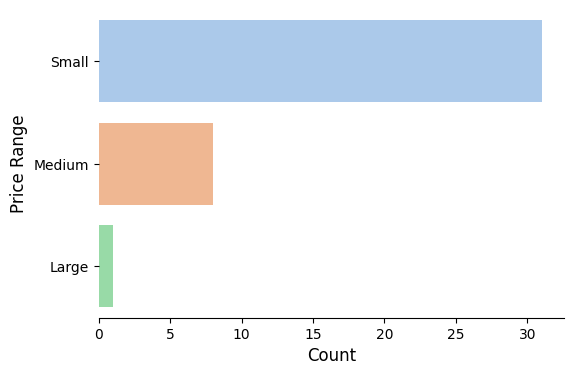

In [ ]:
sns.set_palette("pastel")

# Create a horizontal bar plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(y='range', data=df, palette="pastel")

plt.xlabel('Count', fontsize=12)
plt.ylabel('Price Range', fontsize=12)
sns.despine(left=True)

plt.show()

The data consists of mostly small fridges with 31 of the 40 fridges in the data set being small, and 7 being medium and 2 being large.

In [ ]:

fig = px.box(df, x='range', y='review', color='range',
             color_discrete_sequence=px.colors.qualitative.Plotly,
             title='Range vs Review',
             labels={'range': 'Price Range', 'review': 'Review'},
             template='plotly_white')

fig.update_layout(title_font=dict(size=20), xaxis_tickfont=dict(size=12), yaxis_tickfont=dict(size=12),
                  showlegend=False, autosize=False, width=600, height=400
                  )

fig.show()


The small fridges fall cover a wide range of user reviews, so we cannot determine which would be best for the user, while the medium fridges range between 4.5 and 4.0, which are very good reviews, and the large fridges range from 5.0 and 4.25 having the best range of reviews

From our analysis, I would advice the user to get either a Skyrun or a Nexus refrigerator because of their high popularity amongst customers, they also have very good average ratings amongst other brands of refrigerators.